In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import emformer
import s3prl.hub

import torchaudio
import nema_data

C:\Users\tejas\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def mngu0_to_hprc(mng_arr):
    td = mng_arr[:, 0:2]
    tb = mng_arr[:, 2:4]
    tt = mng_arr[:, 4:6]
    li = mng_arr[:, 6:8]
    ul = mng_arr[:, 8:10]
    ll = mng_arr[:, 10:12]

    hprc_arr = np.zeros_like(mng_arr)
    hprc_arr[:, 0:2] = li
    hprc_arr[:, 2:4] = ul
    hprc_arr[:, 4:6] = ll
    hprc_arr[:, 6:8] = tt
    hprc_arr[:, 8:10] = tb
    hprc_arr[:, 10:12] = td


    for i in range(0, 12, 2):
        hprc_arr[:, i] = hprc_arr[:, i] * -1

    return hprc_arr

In [18]:
ema_gt = np.load("static/ema/mngu0_s1_0008.npy")

In [19]:
ema_gt = mngu0_to_hprc(ema_gt)

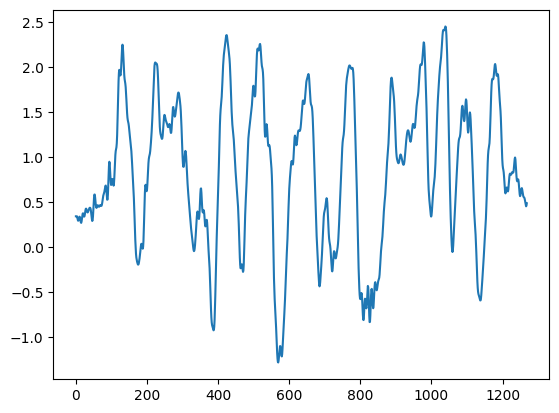

In [20]:
plt.plot(ema_gt[:, 0], label="x")

In [7]:
np.save("static/mngu0_s1_0008.npy", ema_gt)

In [11]:
def get_feature_model():
    print("--- Getting WavLM feature extractor ---")

    feature_model = getattr(s3prl.hub, "wavlm_large")()
    feature_model = feature_model.model.feature_extractor

    print("--- Loaded WavLM feature extractor ---")

    return feature_model

def get_emformer_model():
    print("--- Getting pretrained Emformer ---")

    input_dim=512
    num_heads=16
    ffn_dim=512
    num_layers=15
    segment_length=5
    left_context_length=20

    emformer_model = emformer.EMAEmformer(
        input_dim=input_dim,
        num_heads=num_heads,
        ffn_dim=ffn_dim,
        num_layers=num_layers,
        segment_length=segment_length,
        left_context_length=left_context_length
    )

    ckpt = torch.load(f"ckpts/emf_l{left_context_length}_r0_p{segment_length}_nh{num_heads}__nl{num_layers}_ffd{ffn_dim}_0.89.pth", map_location="cuda:0")

    emformer_model.load_state_dict(ckpt["emformer_state_dict"])

    print("--- Loaded pretrained Emformer ---")

    return emformer_model

In [12]:
feature_model = get_feature_model()

--- Getting WavLM feature extractor ---
--- Loaded WavLM feature extractor ---


In [13]:
emformer_model = get_emformer_model()

--- Getting pretrained Emformer ---
--- Loaded pretrained Emformer ---


In [7]:
audio, sr = torchaudio.load("static/wav/mngu0_s1_0008.wav")
#audio = audio.squeeze(0)
feats = feature_model(audio)
print(feats.shape)
feats = feats.transpose(1, 2)

NameError: name 'feature_model' is not defined

In [17]:
ema_pred, state = emformer_model.predict_ema(feats, None)

In [18]:
ema_pred_hprc = mngu0_to_hprc(ema_pred)
np.save("static/mngu0_s1_0008_emf.npy", ema_pred_hprc)

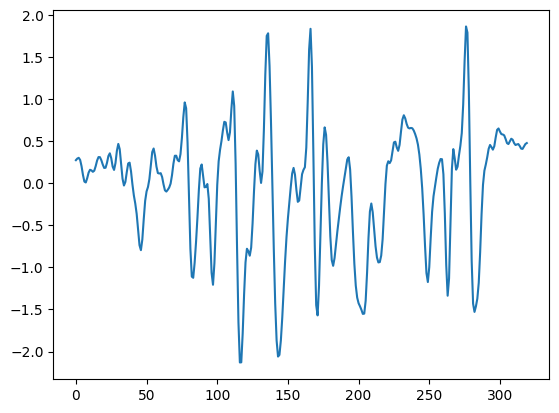

In [19]:
plt.plot(ema_pred[:, 7], label="y")

In [50]:
ema_pred, state = emformer_model.predict_ema(feats, None)

In [1]:
from transformers import Wav2Vec2Processor, Wav2Vec2FeatureExtractor, WavLMModel

C:\Users\tejas\AppData\Roaming\Python\Python38\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
wavlm = WavLMModel.from_pretrained("microsoft/wavlm-large")

In [9]:
wavlm.feature_extractor(audio).shape

torch.Size([1, 512, 317])

In [21]:
feature_model = Wav2Vec2FeatureExtractor.from_pretrained("microsoft/wavlm-large")

In [24]:
feature_model(audio, sampling_rate=sr, return_tensors="pt")

{'input_values': tensor([[[-0.0138, -0.0138, -0.0138,  ..., -0.0138, -0.0138, -0.0138]]]), 'attention_mask': tensor([[1]], dtype=torch.int32)}

In [23]:
nema = nema_data.NEMAData(ema_gt[:5], is_file=False, demean=False, normalize=False)

In [24]:
nema.get_json()

{'li': [[0.3709, 0.3709, 0.3709, 0.3709, 0.3611],
  [0.341, 0.341, 0.341, 0.341, 0.3256]],
 'ul': [[-0.4672, -0.4672, -0.4672, -0.4672, -0.4838],
  [0.7996, 0.7996, 0.7996, 0.7996, 0.8175]],
 'll': [[0.2316, 0.2316, 0.2316, 0.2316, 0.2405],
  [-0.0309, -0.0309, -0.0309, -0.0309, -0.0322]],
 'tt': [[-0.561, -0.561, -0.561, -0.561, -0.5622],
  [0.9725, 0.9725, 0.9725, 0.9725, 0.99]],
 'tb': [[-0.8666, -0.8666, -0.8666, -0.8666, -0.8582],
  [0.2159, 0.2159, 0.2159, 0.2159, 0.231]],
 'td': [[-1.2006, -1.2006, -1.2006, -1.2006, -1.1923],
  [-0.0715, -0.0715, -0.0715, -0.0715, -0.0463]]}

In [4]:
import pathlib
import numpy as np

In [2]:
path = pathlib.Path("../wav2avatar/inversion/ema/cj_journal/web/")

In [17]:
for mng_npy in path.rglob("*art.npy"):
    ema = np.load(mng_npy)
    ema = ema[:, 0:12]
    ema = ema*raw_ema_scales[None, :] + raw_ema_centers[None, :]
    ema = mngu0_to_hprc(ema)
    np.save(mng_npy, ema)

In [3]:
raw_ema_centers =  np.array([ 5.4639918 , -0.3087816 , 
                            3.91374076,  0.05992909, 
                            2.25575548,  -0.54491236,  
                            0.84374439,  -2.80131028, 
                            -1.0093638 , -0.0821571 ,
                            -0.67026269, -2.56050042])
raw_ema_scales =   np.array( [0.23050117, 0.3493298,
                                0.25980174, 0.33585748,
                                0.28547019, 0.3328375,
                                0.10304348, 0.17058368,
                                0.05892932, 0.08087073,
                                0.12812408, 0.24127527])

In [14]:
ema = np.load(path / "spain_art.npy")
ema = ema*raw_ema_scales[None, :] + raw_ema_centers[None, :]
ema = mngu0_to_hprc(ema)
np.save(path / "spain.npy", ema)

In [19]:
ema = np.load(path / "venture_art.npy")
ema = ema*raw_ema_scales[None, :] + raw_ema_centers[None, :]
ema = mngu0_to_hprc(ema)
np.save(path / "venture.npy", ema)

In [4]:
ema = np.load("D:/Documents/UCBerkeley/2023-2024/r1b/converted_full_audio/husband_ema.npy")
ema = ema*raw_ema_scales[None, :] + raw_ema_centers[None, :]
ema = mngu0_to_hprc(ema)
np.save("D:/Documents/UCBerkeley/2023-2024/r1b/converted_full_audio/husband_ema_hprc.npy", ema)

In [5]:
def save_ema(name):
    ema = np.load(f"D:/Documents/UCBerkeley/2023-2024/r1b/converted_full_audio/{name}_ema.npy")
    ema = ema*raw_ema_scales[None, :] + raw_ema_centers[None, :]
    ema = mngu0_to_hprc(ema)
    np.save(f"D:/Documents/UCBerkeley/2023-2024/r1b/converted_full_audio/{name}_ema_hprc.npy", ema)

In [6]:
save_ema("alma")
save_ema("bergman")
save_ema("elisabet")
save_ema("doctor")